## Load packages

In [1]:
# Loading libraries
import random
import matplotlib.pyplot as plt             # Library used for plotting
from matplotlib.patches import Rectangle    # Module to plot a rectangle in the image
import urllib.request                       # Library to download data
import numpy as np                          # Library for array manipulation
import seaborn as sn                        # Library for advanced plotting
import pandas as pd                         # Library to manipulate data frames
import tifffile                             # Library to store numpy arrays as TIFF
import pathlib                              # Library to work with file paths
from pathlib import Path                    # Library to work with file paths
import skimage                              # Library for image manipulation. scikit-image
from skimage.io import imread               # Module from skimage
from matplotlib import animation            # Module to plot animations
from skimage import io, measure               # Module from skimage
from skimage.filters import gaussian # Module working with a gaussian filter
import os
%matplotlib inline

from ipywidgets import interactive, HBox, VBox, Layout
import ipywidgets as widgets

from skimage.morphology import binary_dilation
from skimage.segmentation import watershed
from skimage.draw import polygon
from skimage.measure import regionprops
from skimage.color import label2rgb
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion
from skimage.morphology import binary_closing
from skimage.morphology import binary_opening
from skimage.morphology import disk
from skimage.morphology import remove_small_objects
from scipy import ndimage as ndi              # Distance Transform
from skimage.feature import peak_local_max    # Local maxima in a matrix
from skimage.segmentation import watershed    # Watershed algorithm
from skimage.filters import difference_of_gaussians
from cellpose import plot, models
from skimage.morphology import remove_small_objects

## Preprocessing

In [29]:
img_0 = []
for i in range(6):
    figName = './NoDrug/rep1_FOV' + str(i+1) + '.tif'
    img = imread(str(figName))
    img_0.append(img)
    figName = './NoDrug/rep2_FOV' + str(i+1) + '.tif'
    img = imread(str(figName))
    img_0.append(img)

img_3 = []
for i in range(6):
    figName = './Drug3_1000nM/rep1_FOV' + str(i+1) + '.tif'
    img = imread(str(figName))
    img_3.append(img)
    figName = './Drug3_1000nM/rep2_FOV' + str(i+1) + '.tif'
    img = imread(str(figName))
    img_3.append(img)

img_6 = []
for i in range(6):
    figName = './Drug6_1000nM/rep1_FOV' + str(i+1) + '.tif'
    img = imread(str(figName))
    img_6.append(img)
    figName = './Drug6_1000nM/rep2_FOV' + str(i+1) + '.tif'
    img = imread(str(figName))
    img_6.append(img)


figName = './NoDrug/rep1_FOV1.tif'
img = imread(str(figName))
img_mix = [img]
for i in range(3,7):
    figName = './Drug' + str(i) + '_1000nM/rep1_FOV1.tif'
    img = imread(str(figName))
    img_mix.append(img)

### VIEWER: Three color frames with with FOV and time slider

In [30]:
def three_color_viewer(fov=1,time=1):
    '''
    This function is intended to display an image from an array of images (specifically, video: img_int8). 
         img_int8 is a numpy array with dimension [T,Y,X,C].
    drop_channel : str with options 'Ch_0', 'Ch_1', 'Ch_2', 'All'
    time: int with range 0 to the number of frames in video.
    '''
    # img = img_0[fov]
    img = img_6[fov]
    fig, axes = plt.subplots(1,3,dpi=120,figsize=(8,3))
    Red = img[time,:,:,0]
    im1 = axes[0].imshow(Red,cmap='Reds_r')
    Green = img[time,:,:,1]
    im2 = axes[1].imshow(Green,cmap='Greens_r')
    Blue = img[time,:,:,2]
    im3 =  axes[2].imshow(Blue,cmap='Blues_r')
    axes[0].axis('off')
    axes[1].axis('off')
    axes[2].axis('off')
    plt.show()

interactive_plot = interactive(three_color_viewer, fov = widgets.IntSlider(min=0,max=len(img_0)-1,step=1,value=0,description='FOV'),
                               time = widgets.IntSlider(min=0,max=img.shape[0]-1,step=1,value=0,description='time frame'))
controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap'))
output = interactive_plot.children[-1]

display(VBox([controls, output]))

### VIEWER: Three color frame with different drugs

In [28]:
def three_color_mix_viewer(drug=1,time=1):
    '''
    This function is intended to display an image from an array of images (specifically, video: img_int8). 
         img_int8 is a numpy array with dimension [T,Y,X,C].
    drop_channel : str with options 'Ch_0', 'Ch_1', 'Ch_2', 'All'
    time: int with range 0 to the number of frames in video.
    '''
    img = img_mix[drug]
    fig, axes = plt.subplots(1,3,dpi=120,figsize=(8,3))
    Red = img[time,:,:,0]
    im1 = axes[0].imshow(Red,cmap='Reds_r')
    Green = img[time,:,:,1]
    im2 = axes[1].imshow(Green,cmap='Greens_r')
    Blue = img[time,:,:,2]
    im3 =  axes[2].imshow(Blue,cmap='Blues_r')
    axes[0].axis('off')
    axes[1].axis('off')
    axes[2].axis('off')
    plt.show()

interactive_plot = interactive(three_color_mix_viewer, drug = widgets.IntSlider(min=0,max=len(img_mix)-1,step=1,value=0,description='drug'),
                               time = widgets.IntSlider(min=0,max=img.shape[0]-1,step=1,value=0,description='time frame'))
controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap'))
output = interactive_plot.children[-1]

display(VBox([controls, output]))

## Information of nuc and cyt

### masks

In [4]:
img = img_0[0]
t = 0

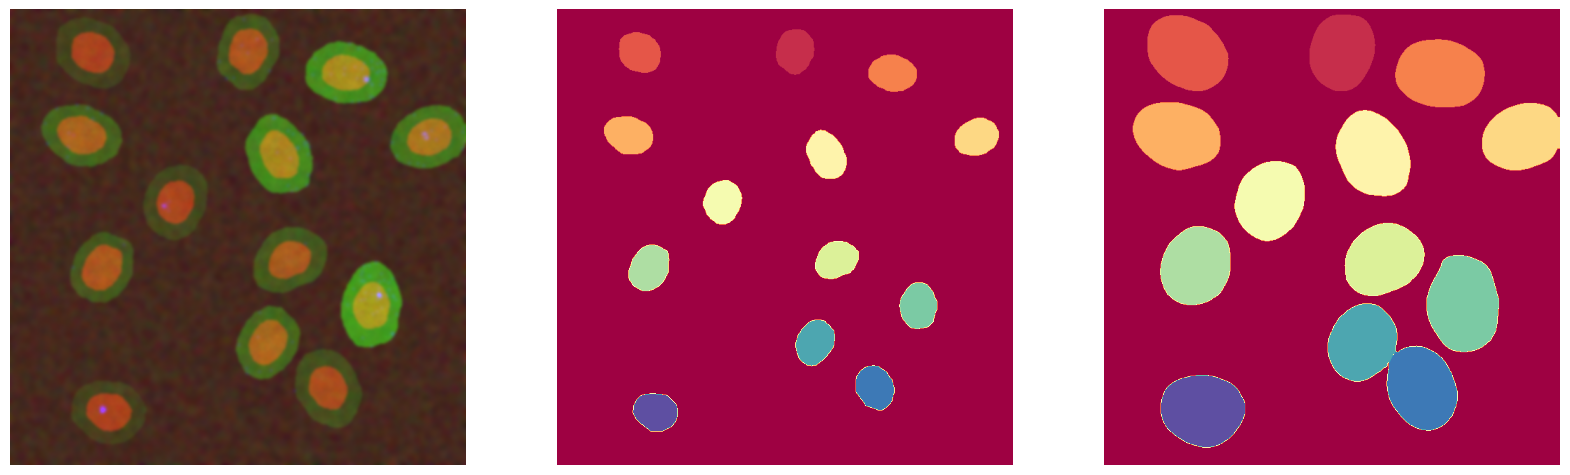

Number of nuclei: 13
Number of cytoplast: 13


In [5]:
img_nuc = img[t,:,:,0]
model = models.Cellpose(model_type='nuclei') # model_type='cyto' or model_type='nuclei'
masks_nuc  = model.eval(img_nuc, diameter=100, channels=[0,1])[0]
masks_nuc = remove_small_objects(masks_nuc, min_size=50)

img_cyto = img[t,:,:,1]
model = models.Cellpose(model_type='cyto') # model_type='cyto', 'cyto2' or model_type='nuclei'
masks_cyto, flows, styles, diams = model.eval(img_cyto, diameter=200, channels=[0,2])

nucleus_indices = np.zeros(np.max(masks_cyto)+1,dtype=int)
for i in range(1, np.max(masks_nuc)+1):
    posn_nucl = np.mean(np.where(masks_nuc==i),axis=1).astype(int)
    nucleus_indices[masks_cyto[posn_nucl[0], posn_nucl[1]]] = i

number_detected_cells = np.max([masks_cyto, masks_nuc])

# Plotting each one of the 3 colors independently
fig, ax = plt.subplots(1, 3, figsize=(20, 7))
ax[0].imshow(img[t,:,:,:])
ax[1].imshow(masks_nuc,cmap='Spectral')
ax[2].imshow(masks_cyto,cmap='Spectral')

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

print(f'Number of nuclei: {len(np.unique(masks_nuc))-1}')
print(f'Number of cytoplast: {len(np.unique(masks_cyto))-1}')

### area

In [6]:
list_cyt_areas = []
list_nuc_areas = []
for i in range (1,number_detected_cells+1):
  selected_cyto_mask = (masks_cyto==i)
  area_cyto = np.sum(selected_cyto_mask)
  list_cyt_areas.append(area_cyto)
  selected_nuc_mask = (masks_nuc==nucleus_indices[i])
  area_nuc = np.sum(selected_nuc_mask)
  list_nuc_areas.append(area_nuc)

### protein intensity

In [7]:
list_cyt_intensities = []
for i in range (1, number_detected_cells+1):
  selected_mask = (masks_cyto==i)
  selected_color_image = selected_mask*img_cyto
  list_cyt_intensities.append(selected_color_image[np.nonzero(selected_color_image)].mean())

## Information of mRNA

### Gaussian filter

C:\Users\yy5019\AppData\Local\Temp\ipykernel_13944\1996610137.py:20: RuntimeWarning: divide by zero encountered in log10
  ax[1,1].plot(survival, np.log10(np.arange(len(survival))))


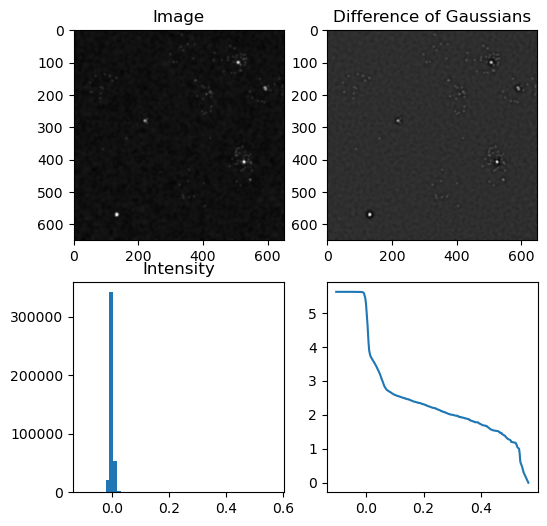

intensity range:  -0.10291584431207496 0.5708251948423355


In [8]:
img_spots = img[0,:,:,2]

# Show the original image
fig, ax = plt.subplots(2,2, figsize=(6, 6))
ax[0,0].imshow(img_spots,cmap='Greys_r')
ax[0,0].set(title='Image')

# Apply a difference of Gaussians filter to the image to enhance spots
img_spots_filtered = difference_of_gaussians(img_spots,low_sigma=1, high_sigma=5)
ax[0,1].imshow(img_spots_filtered,cmap='Greys_r')
ax[0,1].set(title= 'Difference of Gaussians' )

# Make a histogram of the intensity values
ax[1,0].hist(img_spots_filtered.flatten(),bins=50)
ax[1,0].set(title= 'Intensity' )

# Make a survival plot of the intensity values
survival = np.sort(img_spots_filtered.flatten())
survival = survival[::-1]
ax[1,1].plot(survival, np.log10(np.arange(len(survival))))

plt.show()
print('intensity range: ', np.min(img_spots_filtered), np.max(img_spots_filtered))

### VIEWER: mRNA with threshold and time slider

In [9]:
def mRNA_viewer(time=1, threshold=100):
    img_spots = img[time,:,:,2]  # selecting a time point
    img_spots_filtered = difference_of_gaussians(img_spots,low_sigma=1, high_sigma=5)
    selected_tp_img = img_spots_filtered.copy()
    threshold = threshold/100

    # Image binarization
    selected_tp_img[selected_tp_img>=threshold] = 255
    selected_tp_img[selected_tp_img<threshold] = 0
    selected_tp_img[selected_tp_img!=0] = 1

    fig, ax = plt.subplots(1,4, figsize=(15, 5))
    ax[0].imshow(img_spots,cmap='Greens_r')
    ax[0].set_title('Simulated spots')
    ax[1].imshow(img_spots_filtered,cmap='Greys_r')
    ax[1].set_title('Difference of Gaussians' )
    ax[2].imshow(selected_tp_img,cmap='Greys_r')
    ax[2].set_title('Binary image')

    # Joining pixels in "particles"
    contours = measure.find_contours(selected_tp_img, 0.5)
    ax[3].imshow(selected_tp_img, cmap=plt.cm.gray)
    for contour in contours:
        ax[3].plot(contour[:, 1], contour[:, 0], linewidth=2)
    ax[3].set_title(f'#{len(contours)} sites contour plots')
    plt.show()

interactive_plot = interactive(mRNA_viewer,
                               time = widgets.IntSlider(min=0,max=len(img)-1,step=1,description='time'),
                               threshold = widgets.IntSlider(min=1,max=20,step=1,description='threshold'))
# Creates the controls
controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap'))
# Creates the outputs
output = interactive_plot.children[-1]

# Display the controls and output as an interactive widget
display(VBox([controls, output]))

### Threshold and mask

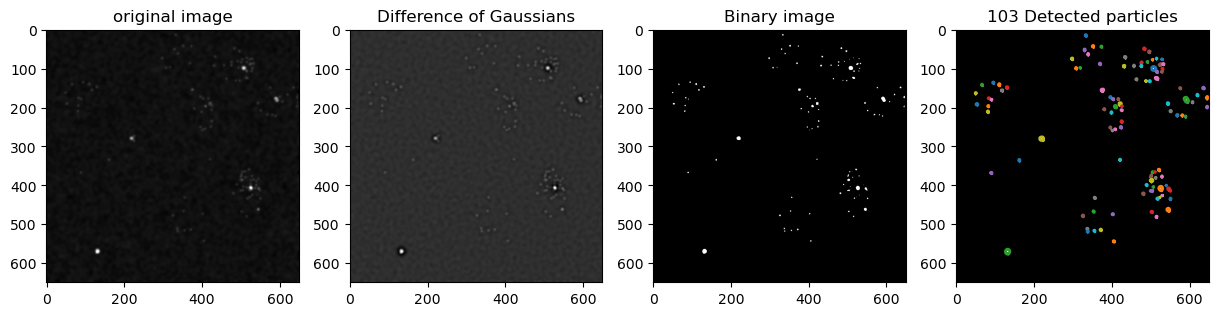

In [10]:
threshold = 0.05

# Show original image in MS2 channel
fig, ax = plt.subplots(1,4, figsize=(15, 6))
ax[0].imshow(img_spots,cmap='Greys_r')
ax[0].set(title='original image')

# Apply a difference of Gaussians filter to the image to enhance spots
ax[1].imshow(img_spots_filtered,cmap='Greys_r')
ax[1].set(title= 'Difference of Gaussians' )

# Apply a Threshold to the image to create binary image
img_spots_binary = img_spots_filtered.copy()
img_spots_binary[img_spots_binary>=threshold] = threshold
img_spots_binary[img_spots_binary<threshold] = 0
ax[2].imshow(img_spots_binary,cmap='Greys_r')
ax[2].set(title= 'Binary image' )

# Image binarization
img_spots_binary[img_spots_binary!=0] = 1
ax[3].imshow(img_spots_binary, cmap=plt.cm.gray)

# Labeling. Joining pixels in "particles"
spot_contours = measure.find_contours(img_spots_binary, 0.5)
for contour in spot_contours:
    ax[3].plot(contour[:, 1], contour[:, 0], linewidth=2)
ax[3].set(title= str(len(spot_contours))+' Detected particles' )
plt.show()

### number of mRNA particles

In [11]:
# Counting the detected particles in each cell
list_cytosol_particles = np.zeros(number_detected_cells)
list_nuclear_particles = np.zeros(number_detected_cells)

for i in range(len(spot_contours)):
    posn = np.mean(spot_contours[i], axis=0).astype(int)

    cell_num_nuc = masks_nuc[posn[0], posn[1]]
    cell_num_cyto = masks_cyto[posn[0], posn[1]]
    if cell_num_nuc>0:
        list_nuclear_particles[nucleus_indices[cell_num_nuc]-1] += 1
    elif cell_num_cyto>0:
        list_cytosol_particles[cell_num_cyto-1] += 1

## VIEWER: single cell with nuc, cyt and mRNA

In [12]:
def CELL_viewer(cell_num=1):
    '''
    This function is intended to display an image from an array of images (specifically, video: img_int8). 
         img_int8 is a numpy array with dimension [T,Y,X,C].
    drop_channel : str with options 'Ch_0', 'Ch_1', 'Ch_2', 'All'
    time: int with range 0 to the number of frames in video.
    '''
    selected_cyto_mask = masks_cyto==cell_num
    selected_nuc_mask = masks_nuc==nucleus_indices[cell_num]

    # Crop the original image to show just the selected cell
    image_cropped = img_cyto.copy()
    image_cropped[~selected_cyto_mask] = 0

    # remove rows and columns that are all zeros
    rows = np.any(image_cropped[:,:], axis=1)
    rlims = [np.min(np.where(rows)), np.max(np.where(rows))]
    cols = np.any(image_cropped[:,:,], axis=0)
    clims = [np.min(np.where(cols)), np.max(np.where(cols))]
    image_cropped = img[0, rlims[0]:rlims[1], clims[0]:clims[1]]

    # display the cropped image
    fig, ax = plt.subplots(1,1, figsize=(8, 8))
    ax.imshow(image_cropped[:,:],cmap='Spectral_r')

    # draw the contours of the cytosol and nucleus
    cyto_contours = measure.find_contours(selected_cyto_mask, 0.5)
    nuc_contours = measure.find_contours(selected_nuc_mask, 0.5)
    for contour in cyto_contours:
        ax.plot(contour[:, 1]-clims[0], contour[:, 0]-rlims[0], linewidth=2, color='g', alpha=0.5)
    for contour in nuc_contours:
        ax.plot(contour[:, 1]-clims[0], contour[:, 0]-rlims[0], linewidth=2, color='r', alpha=0.5)

    # Add the contours of the particles to the image
    for contour in spot_contours:
        # Check if the particle is in the selected cell
        posn = np.mean(contour, axis=0).astype(int)
        if selected_cyto_mask[posn[0], posn[1]]:
            ax.plot(contour[:, 1]-clims[0], contour[:, 0]-rlims[0], linewidth=2, color='b', alpha=0.5)
    ax.axis('off')
    plt.show()

interactive_plot = interactive(CELL_viewer, cell_num = widgets.IntSlider(min=0,max=number_detected_cells,step=1,description='cell index'))     
controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap'))
output = interactive_plot.children[-1]

display(VBox([controls, output]))

## Transcription site

### Max intensity and gaussian filter

C:\Users\yy5019\AppData\Local\Temp\ipykernel_13944\2361437320.py:20: RuntimeWarning: divide by zero encountered in log10
  ax[1,1].plot(survival, np.log10(np.arange(len(survival))))


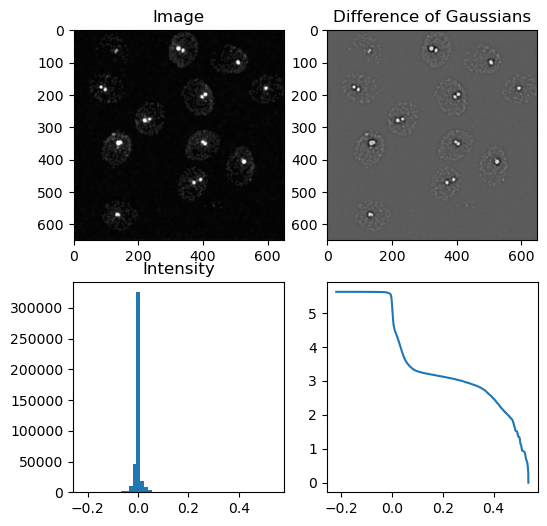

intensity range:  -0.2201008412083973 0.5421032128659986


In [13]:
img_site = np.max(img[:,:,:,2], axis=0)

# Show the original image
fig, ax = plt.subplots(2,2, figsize=(6, 6))
ax[0,0].imshow(img_site,cmap='Greys_r')
ax[0,0].set(title='Image')

# Apply a difference of Gaussians filter to the image to enhance spots
img_sites_filtered = difference_of_gaussians(img_site, low_sigma=1, high_sigma=5)
ax[0,1].imshow(img_sites_filtered,cmap='Greys_r')
ax[0,1].set(title= 'Difference of Gaussians' )

# Make a histogram of the intensity values
ax[1,0].hist(img_sites_filtered.flatten(),bins=50)
ax[1,0].set(title= 'Intensity' )

# Make a survival plot of the intensity values
survival = np.sort(img_sites_filtered.flatten())
survival = survival[::-1]
ax[1,1].plot(survival, np.log10(np.arange(len(survival))))

plt.show()
print('intensity range: ', np.min(img_sites_filtered), np.max(img_sites_filtered))

### VIEWER: max site with threshold

In [14]:
def SITE_viewer(FOV=1,threshold=100):
    img = img_0[FOV]
    img_site = np.max(img[:,:,:,2], axis=0)
    img_sites_filtered = difference_of_gaussians(img_site, low_sigma=1, high_sigma=5)
    threshold = threshold/100

    ## Image binarization
    img_tracking = img_sites_filtered.copy()
    img_tracking[img_tracking>threshold] = 255
    img_tracking[img_tracking<threshold] = 0
    img_tracking[img_tracking!=0] = 1
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    ax[0].imshow(img_site,cmap='Greens_r')
    ax[0].set_title('Simulated spots')
    ax[1].imshow(img_sites_filtered,cmap='Greys_r')
    ax[1].set(title= 'Difference of Gaussians' )
    ax[2].imshow(img_tracking,cmap='Greys_r')
    ax[2].set_title('Binary image')

    # Joining pixels in "particles"
    contours = measure.find_contours(img_tracking, 0.5)
    ax[3].imshow(img_tracking, cmap=plt.cm.gray)
    for contour in contours:
        ax[3].plot(contour[:, 1], contour[:, 0], linewidth=2)
    ax[3].set_title(f'#{len(contours)} sites contour plots')
    plt.show()

interactive_plot = interactive(SITE_viewer,
                               FOV = widgets.IntSlider(min=0,max=len(img_0)-1,step=1,description='FOV'),
                               threshold = widgets.IntSlider(min=5,max=100,step=5,description='threshold'))
controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap'))
output = interactive_plot.children[-1]

display(VBox([controls, output]))

### threshold and mask

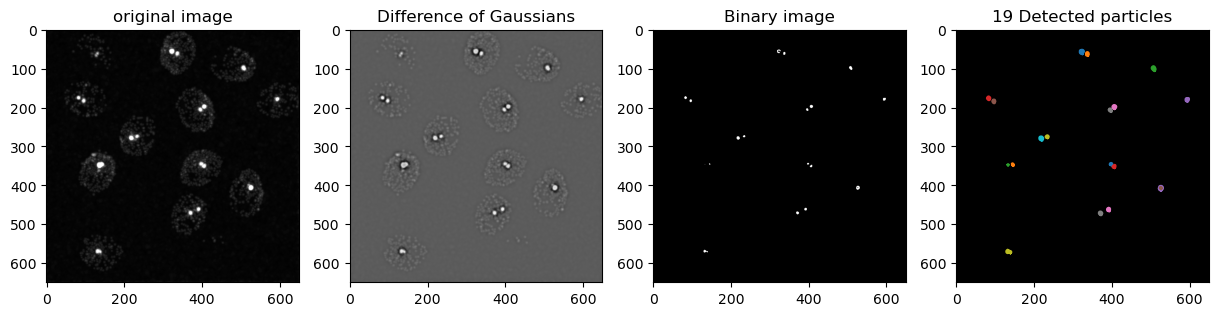

In [15]:
threshold = 0.35

# Show original image in MS2 channel
fig, ax = plt.subplots(1,4, figsize=(15, 6))
ax[0].imshow(img_site,cmap='Greys_r')
ax[0].set(title='original image')

# Apply a difference of Gaussians filter to the image to enhance spots
ax[1].imshow(img_sites_filtered,cmap='Greys_r')
ax[1].set(title= 'Difference of Gaussians' )

# Apply a Threshold to the image to create binary image
img_sites_binary = img_sites_filtered.copy()
img_sites_binary[img_sites_binary>=threshold] = threshold
img_sites_binary[img_sites_binary<threshold] = 0
ax[2].imshow(img_sites_binary,cmap='Greys_r')
ax[2].set(title= 'Binary image' )

# Image binarization
img_sites_binary[img_sites_binary!=0] = 1 # Binarization
ax[3].imshow(img_sites_binary, cmap=plt.cm.gray)

# Labeling. Joining pixels in "particles"
site_contours = measure.find_contours(img_sites_binary, 0.5)
for contour in site_contours:
    ax[3].plot(contour[:, 1], contour[:, 0], linewidth=2)
ax[3].set(title= str(len(site_contours))+' Detected particles' )
plt.show()

### number of sites

In [16]:
list_site_particles = np.zeros(number_detected_cells)
for i in range(len(site_contours)):
    posn = np.mean(site_contours[i], axis=0).astype(int)

    # Check which nuc mask is the site in
    cell_num = masks_nuc[posn[0], posn[1]]
    if cell_num>0:
        list_site_particles[nucleus_indices[cell_num]-1] += 1

### 1st and 2nd site intensity

center intensity or mean intensity of max 2 intensity?

In [21]:
list_site_intensities = np.zeros(number_detected_cells)
list_site_intensities_1 = np.zeros(number_detected_cells)
list_site_intensities_2 = np.zeros(number_detected_cells)
try_int = np.zeros(number_detected_cells)

selected_mask = (img_sites_binary > 0)
for i in range (1, number_detected_cells+1):
    selected_nuc_mask = (masks_nuc == i)
    selected_color_image = selected_mask*selected_nuc_mask*img_spots
    selected_nonzero = selected_color_image[np.nonzero(selected_color_image)]
    if selected_nonzero.size > 0:
        list_site_intensities[nucleus_indices[i]-1] = selected_nonzero.mean()
        list_site_intensities_1[nucleus_indices[i]-1] = np.max(selected_nonzero)
        list_site_intensities_2[nucleus_indices[i]-1] = np.partition(selected_nonzero,-2)[-2]
        try_int[nucleus_indices[i]-1] = np.partition(selected_nonzero,-1)[-1]

## Overall dataframe

In [23]:
df = pd.DataFrame(list(range(1,number_detected_cells+1)), columns=['cell index'])
# df['time'] = np.array([t for i in range(number_detected_cells)])
df['nucleus area'] = np.array(list_nuc_areas).astype(int)
df['cytosol area'] = np.array(list_cyt_areas).astype(int)
df['protein intensity'] = list_cyt_intensities
df['mRNA in cytosol'] = list_cytosol_particles.astype(int)
df['mRNA in nucleus'] = list_nuclear_particles.astype(int)
df['site in nucleus'] = list_site_particles.astype(int)
df['site mean intensity'] = list_site_intensities
df['site 1st intensity'] = list_site_intensities_1.astype(int)
df['site 2nd intensity'] = list_site_intensities_2.astype(int)
df.set_index(df.columns[0], inplace=True)

In [24]:
pd.set_option('display.precision', 2)
df

,nucleus area,cytosol area,protein intensity,mRNA in cytosol,mRNA in nucleus,site in nucleus,site mean intensity,site 1st intensity,site 2nd intensity
cell index,,,,,,,,,
1,2748,8158,81.34,6,3,2,38.49,56,56
2,2769,9572,63.89,0,0,0,0.00,0,0
3,2830,9944,121.76,15,6,1,164.12,221,215
4,2971,9393,88.65,8,3,2,38.97,57,57
5,2655,8561,109.59,9,3,1,115.29,159,152
6,2959,9947,117.72,13,2,2,38.09,58,55
7,2636,8824,66.98,0,1,2,88.14,165,160
8,2568,8986,81.63,1,0,2,31.02,33,32
9,2941,8879,77.29,2,0,2,28.00,28,28
